# Sumary of main results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Input data

In [2]:
RF_models = [
    'RF-accuracy', 'RF-balanced accuracy', 'class weigthed RF-balanced accuracy', 'bootstrap class weigthed RF-balanced accuracy',
    'balanced RF-balanced accuracy', 'easy ensemble-balanced accuracy', 'balanced RF-F1', 'balanced RF-precision',
    '8 features balanced RF-F1']
RF_POD = [29.186, 36.173, 30.916, 31.477, 95.287, 85.432, 94.693, 94.693, 96.110]
RF_FAR = [0.026, 0.540, 0.446, 0.420, 13.739, 17.362, 13.413, 13.413, 9.053]

In [3]:
U_models = ['ld3 fr16', 'ld3 fr64', 'ld3 fr16 p6', 'ld3 fr64 udw', '4 features ld3 fr64']
U_POD = [64.720, 80.708, 64.613, 0., 69.947]
U_FAR = [1.227, 1.998, 1.171, 0., 0.956]

## Create results data frame

In [4]:
df_RF = pd.DataFrame(data={'POD': RF_POD, 'FAR': RF_FAR}, index=RF_models)
df_RF.sort_values(by=['POD', 'FAR'], inplace=True, ascending=[True, False])
df_RF

,POD,FAR
RF-accuracy,29.186,0.026
class weigthed RF-balanced accuracy,30.916,0.446
bootstrap class weigthed RF-balanced accuracy,31.477,0.420
RF-balanced accuracy,36.173,0.540
easy ensemble-balanced accuracy,85.432,17.362
balanced RF-F1,94.693,13.413
balanced RF-precision,94.693,13.413
balanced RF-balanced accuracy,95.287,13.739
8 features balanced RF-F1,96.110,9.053


In [5]:
df_U = pd.DataFrame(data={'POD': U_POD, 'FAR': U_FAR}, index=U_models)
df_U.sort_values(by=['POD', 'FAR'], inplace=True, ascending=[True, False])
df_U

,POD,FAR
ld3 fr64 udw,0.000,0.000
ld3 fr16 p6,64.613,1.171
ld3 fr16,64.720,1.227
4 features ld3 fr64,69.947,0.956
ld3 fr64,80.708,1.998


## Results and discussion

The dataset we are dealing with has two main difficulties. The first one is that there is a significant overlap between the distribution functions of the features for the no hail class and the hail class. The second one is that there is a huge imbalance between the no-hail and the hail class. We had a total of 4351 time steps available for the experiment. 

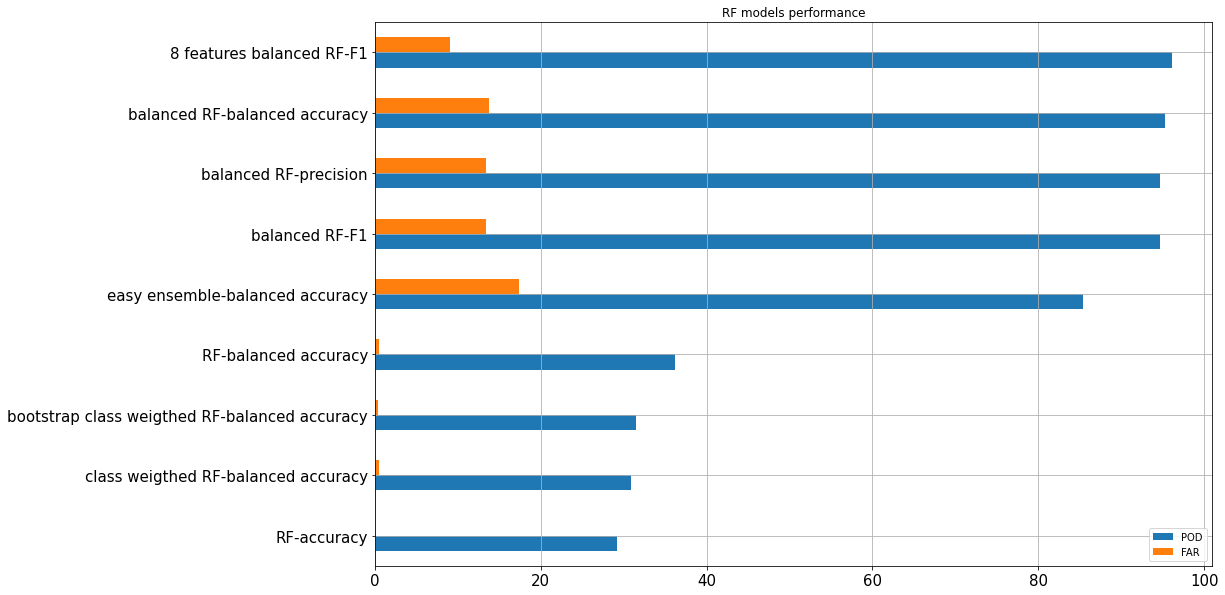

In [6]:
df_RF.plot.barh(figsize=(15,10), title='RF models performance', fontsize=15, grid=True)
plt.show()

RF models have been trained with a set of 3 parameters and their local standard deviation (texture) in a 7x7 km window:
* HRV_norm: The high resolution (1 km) visible channel normalized by the sun position. Useful for cloud top structure
* IR_108: The infrared 10.8 ${\mu m}$. Useful for cloud top height
* WV_068-IR_108: The difference between the water vapour channel and the infrared 10.8 ${}\mu m$ channel, also called window channel. Useful for liquid water content in the cloud

The texture has been introduced to provide some information of the spatial structure in this pixel-based model. To facilitate the training process the data has been thresholded so that the model is only used in areas where hail could occur, i.e. areas with high clouds (IR_108 below 240 K) and significant water content (window channel above -50 K). With these criteria we had a total of 7,432,290 pixels available of which only 61,171 (0.8%) contained hail. 10% of the pixels were reserved for testing and out of the remaining pixels 10% were used for validation.

Classical RF models have difficulties detecting hail due to the fact that pixels containing hail are a small fraction of the total. Using the balanced accuracy (i.e. the average of the recall obtained for each class) does increase slightly the POD at the expense of an increase of the FAR. Changing the class weights when computing the impurity score does not improve the performance of the models. In all these cases the POD is well below 40%. A better solution is to artificially change the class distribution during training so that both classes have a similar number of samples. Indeed, when using balanced random forests or easy ensemble PODs above 90% are achieved albeit at the expense of increasing significantly the FAR. We have experimented trying to optimize for different scores during the grid search (balanced accuracy, precision and F-score) but the results do not change significantly.

Finally, we experimented adding the channel IR_016 which provide information about ice crystals content. We directly experimented with the model deemed to provide the best results: balanced RF with optimization of the F-score in the grid search. Although balanced RF optimized for balanced accuracy was providing a slightly higher POD, we considered F-score to be better since it was providing a slightly lower FAR. The introduction of IR_016 was very positive since it increased slightly the POD and reduced significantly the FAR.  

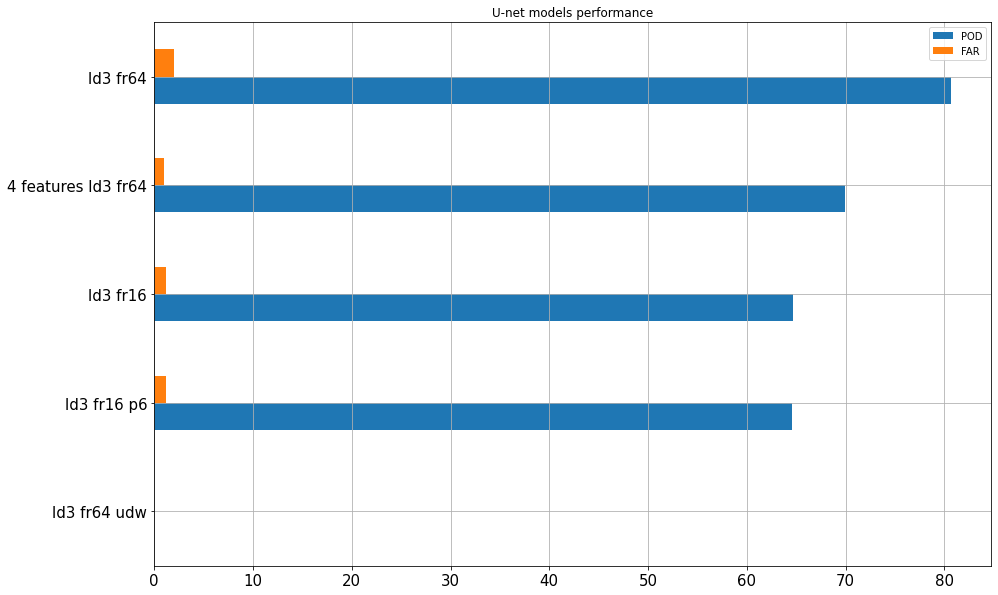

In [7]:
df_U.plot.barh(figsize=(15,10), title='U-net models performance', fontsize=15, grid=True)
plt.show()

u-net models have been trained with the same set of 3 parameters as with the RF models. This time no texture was used since the u-net is expected to learn the spatial structure directly from the images. A total of 4351 images with size 448x256 pixels were used. 351 images were reserved for testing, 400 were used in the validation and the other 3600 were used in the training of the models. Since the entire images were used by the model instead of just a subset the percentage of pixels containing hail dropped further down to 0.1%. To try to overcome the extreme imbalance between classes a weighted binary crossentropy have been used to compute the model losses with weights inversely proportional to the class frequency distribution. The no-hail class was given a weight of 0.5 while the hail class was given a weight on the order of 460. It should be noticed that since no padding was used the size of the predicted image was smaller than that of the input image.

One technical difficulty was that the training of the models was very time consuming. Initially we wanted to train the model using GPUs. Unfortunatelly the u-net software packaged required tensorflow 2.1 or higher while the GPU setup was configured for tensorflow 2.0.0. It was not possible to change the setup since this configuration was used by other operationally-relevant experiments. Hence, instead of GPUs we were limited to using the 8 CPUs of the server. Since the training time was very large and the access to the server from my laptop was performed via tunneling through a 3rd server. The stability of the connection between my laptop and the GPU workstation could not be sustained for a long period. Hence, the training was performed using python scripts runned locally at the GPU workstation. Due to these limitations in computer power the number of experiments that we runned was limited.

The first experiment that we ran was with a u-net architecture consisting of 3 layers with 16 filters in the first layer and a patience of 3 epochs. The training ended after 8 epochs. The behaviour of the validation losses was erratic, which may hint at model overfitting. The model had a somewhat poor detection capability wiht only 64% of pixels correctly identified as hail. To find out whether the tendency for the validation losses to increase was transitory we ran the same model architecture but this time we extended the patience to 6 epochs. The model ran for 11 epochs and the validation losses indeed had a tendency to increase. The prediction results were indeed slightly worse than with the patience 3 model. Increasing the number of filters in the first layer to 64 improved significantly to POD to 80% while only slightly increasing the FAR. However, the model also showed clear overfitting tendencies and it stop after 5 epochs (using a patience of 3 epochs).

An attempt was performed at solving the overfitting by using more moderate weights in the weighted binary crossentropy (0.56 and 5 respectively). However the model completely lost skill and was not able to detect hail at all. Attempts to increase the number of layers to 5 failed because of the dimensions of the input image.

A final experiment was to add another feature (IR_016) to the model. For that experiment we used a u-net with 3 layers and 64 filters in the first layer with a patience of 3 epochs. The POD was actually worse than the results when using the same architecture although the FAR was slightly better. However the training stopped after just 4 epochs because the validation losses had a tendency to increase, hinting at overfitting. Hence, this results may be misleading.    

## Conclusion

The extreme imbalance between the hail-no hail classes, together with the large overlap in the distribution of each feature were major difficulties to tackle in the problem. The best "classical" machine learning model was the balanced random forest model, with very high POD and relatively moderate FAR. The best u-net model architecture that could be evaluated consisted on 3 layers with 64 filters in the first layer. Increasing the number of features proved beneficial in both kinds of models.

The best classical model examined achieved better results than the best deep learning model although a one to one comparison between models is actually not possible since the classical model dealt only with a subset of all the pixels in the images.

The classical model, though, has a couple of advantages respect to the deep learning model. In the first place, since it is pixel-based, it can be re-used over an extended area within Europe since the only parameter depending on location is the normalization factor used for the HRV channel. It is also much faster to train and to make predictions with. Consequently, out of the models examined, the best model would be the balanced random forest optimized by F-score with 4 features.

Although not exceptional, the performance achived with the best models it is deemed sufficient for some applications like the flagging of hail-probable areas for further investigation.

## Recommendations and suggestions for future work

The initial features used in this exercise were selected according to the information they provided as stated in the literature. However it was shown that increasing the number of features may be beneficial for the outcome of the models. The model performance when using all SEVIRI channels and several channel differences as well as subsets of those should be investigated thoroughly. Additional meta-information may also be included in the model such as satellite viewing angle, solar zenith angle, day of the year, solar time, etc.).

It should be also investigated if the use of more features prevents the over-fitting of the u-net model. In such case, more tests with different architectures should be performed. However, we strongly recommend to use a setup that allows the use of GPUs in the training to be able to effectively test the different combinations. Also the use of more CPUs in the training of the RF models would also be highly beneficial. 

Another point that could be investigated further is the sensitivity of the models to the POH threshold. Furthermore, since it relies heavily on visible channels, the current models are valid during daylight only while a significant percentage of hail occurs during the night. Hence, it should be investigated whether a model using only features from the infrared channels can achieve reasonable performances.

Jupyter notebooks were useful for illustration purposes but we strongly recommend to implement the training and testing of the models as a python software package and/or python scripts and run them directly from local servers to avoid undesired interruptions in the processing.